## Data cleaning & Initial exploration

In [2]:
import sqlite3
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
from src.data_utils import get_connection,combine_files
from src.data import SQLRepository
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



**Read files into memory**

In [4]:
df=combine_files("../data/Download Data - STOCK_KE_XNAI_SCOM*.csv")
df.shape

(2499, 6)

**Store data into SQLite 3 database and read**

In [5]:
conn = get_connection()
repo= SQLRepository(conn)


In [6]:
# Insert data
repo.insert_table("scom_prices", df, if_exists="replace")

{'transations_successful': True, 'records_inserted': 2499}

In [7]:
df=repo.read_table("scom_prices")
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2015-05-15,16.20,16.50,16.20,16.35,"9,936,700"
2015-05-18,16.40,16.70,16.35,16.50,"7,844,400"
2015-05-19,16.50,16.75,16.50,16.60,"10,562,300"
2015-05-20,16.60,16.70,16.35,16.45,"10,062,000"
2015-05-21,16.45,16.55,16.25,16.30,"8,668,100"


In [8]:
df.shape

(2499, 5)

### Initial exploration
**Plot of closing prices of Safaricom shares since 2015**

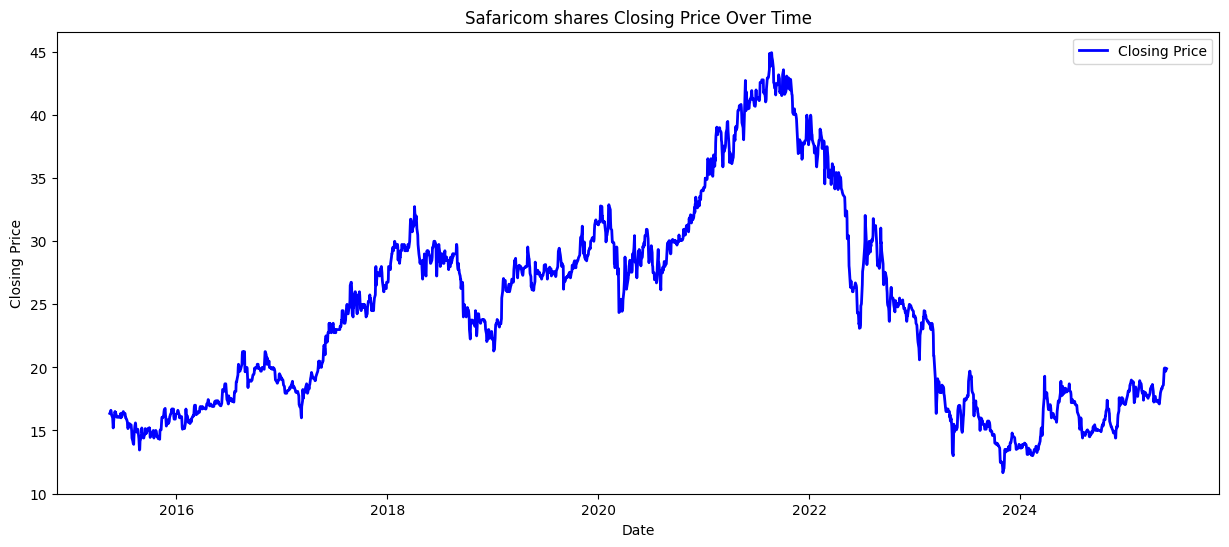

In [9]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(df.index, df['Close'], label='Closing Price', color='blue', linewidth=2)

# Label axes
ax.set_xlabel("Date")
ax.set_ylabel("Closing Price")
ax.set_title("Safaricom shares Closing Price Over Time")

# Add legend
ax.legend();


**Plot of return** <br>
A plot of return is better because it is easier to compare perfomance with other stocks.A return is the change in value in an investment, represented as a percentage.First value is NaN because there is no prev value to compare with.

In [10]:
df['return']=df['Close'].pct_change()*100
df.head()

,Open,High,Low,Close,Volume,return
Date,,,,,,
2015-05-15,16.20,16.50,16.20,16.35,"9,936,700",NaN
2015-05-18,16.40,16.70,16.35,16.50,"7,844,400",0.917431
2015-05-19,16.50,16.75,16.50,16.60,"10,562,300",0.606061
2015-05-20,16.60,16.70,16.35,16.45,"10,062,000",-0.903614
2015-05-21,16.45,16.55,16.25,16.30,"8,668,100",-0.911854


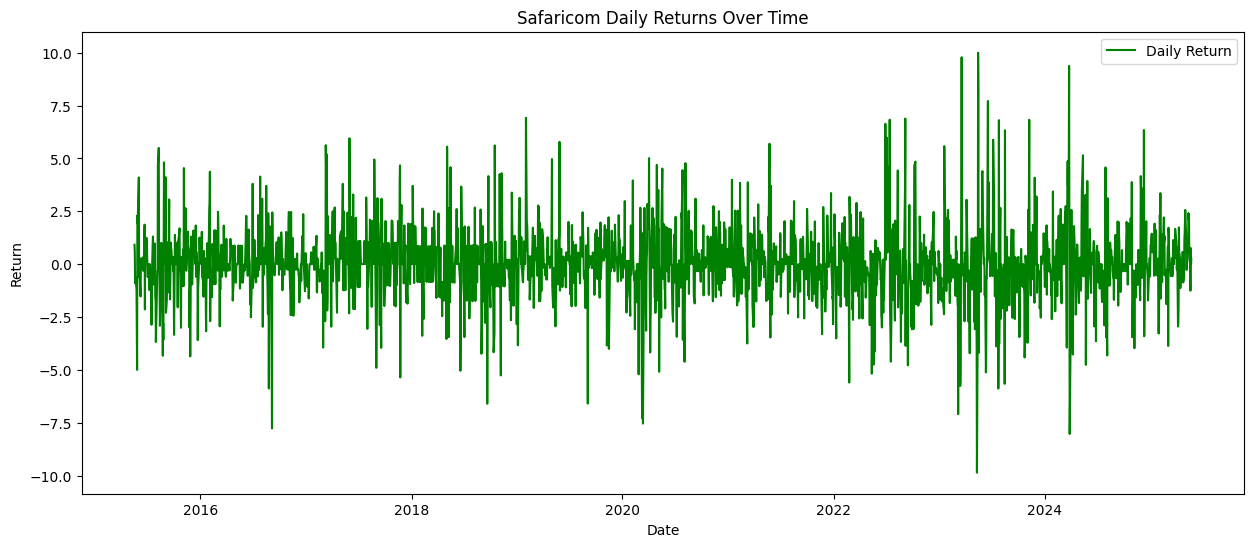

In [11]:
returns=df["return"].dropna()
# Plot returns
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(returns.index, returns, label="Daily Return", color='green')

# Label axes
ax.set_xlabel("Date")
ax.set_ylabel("Return")
ax.set_title("Safaricom Daily Returns Over Time")
# Add legend
ax.legend();

**Histogram** <br>
The returns follow a normal distribution with several key characteristics: <br>
1. Sharp peak at zero-most returns are close to  zero
2. Fat tailed i.e extreme returns occurred more frequently than typical normal distributions
3. Fairly symmetric

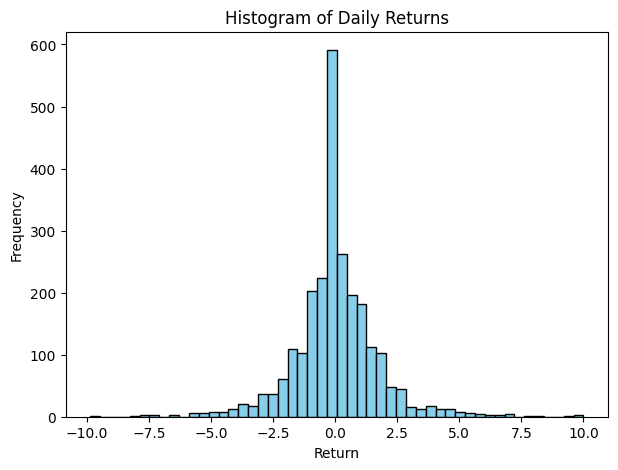

In [12]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.hist(returns, bins=50, color="skyblue", edgecolor="black")
# Label axes
ax.set_xlabel("Return")
ax.set_ylabel("Frequency")
ax.set_title("Histogram of Daily Returns")
plt.show()


**Safaricom shares volatility**

In [13]:
import numpy as np
daily_volatility = np.std(returns) 
annual_volatility = daily_volatility * np.sqrt(252)
print(f"Daily Volatility: {round(daily_volatility,2)}")
print(f"Annualized Volatility: {round(annual_volatility,2)}")


Daily Volatility: 1.7
Annualized Volatility: 26.99


**Rolling Volatility**

To get a clear view of how volatility changes with time, we will plot it alongside returns. From the figure we can infer that as spread in returns increases volatility  increases.Also,there were preriods of high volatility in: <br>
1.Early 2020(When covid started), <br>
2.The better part of 2023.Highest volatility recorded. This extreme spread was due to the following factors: <br>
 -*Government interference* <br>
 -*Expansion into Ethiopia*. The Operation Ethiopia required significant capital which could have impacted earnings <br>
 -*Sell-Downs partly driven by foreign investors* in their desire to seek higher returns in economies performing better than Kenya. <br>
3. Mid 2024. Volatility attributed to the 2024 Finance Bill protests and delays in dividend repatriation.<br>


In [14]:
rolling_volatility = df["return"].rolling(window=50).std().dropna()
rolling_volatility.shape

(2449,)

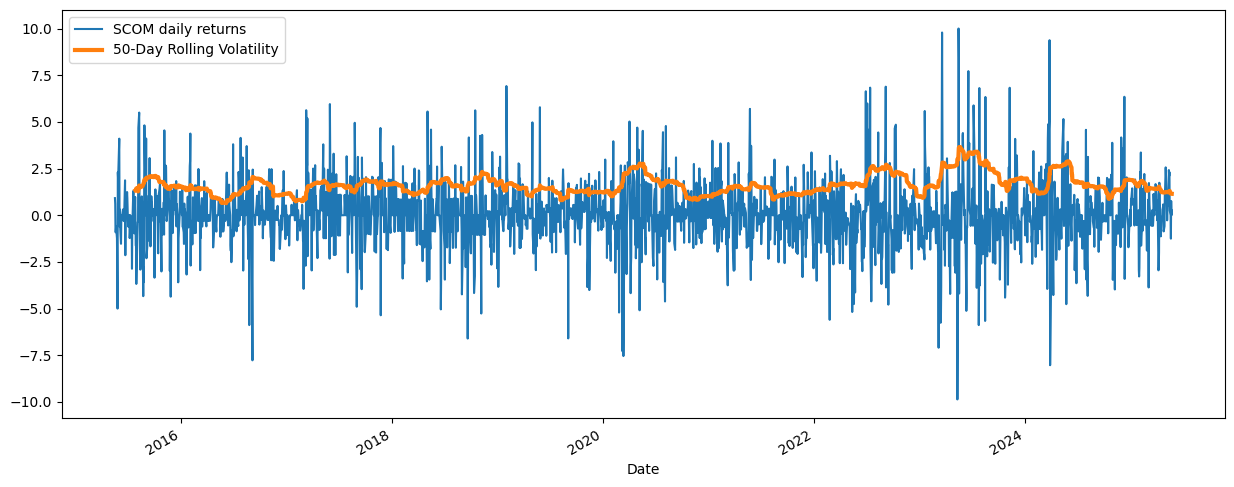

In [15]:
fig, ax = plt.subplots(figsize=(15, 6))
#Plot returns
returns.plot(ax=ax, label="SCOM daily returns")
#Plot SCOM 50 days rolling volatility
rolling_volatility.plot(ax=ax, label='50-Day Rolling Volatility',linewidth=3)
plt.xlabel("Date")
ax.legend();

**Plot of squared returns**
We want to see whether a high volality today is autocorrelated with high volaitility the next day. The perfect way to do this is by plotting squared returns because it allows us to capture both the negative and positive shocks on volality.

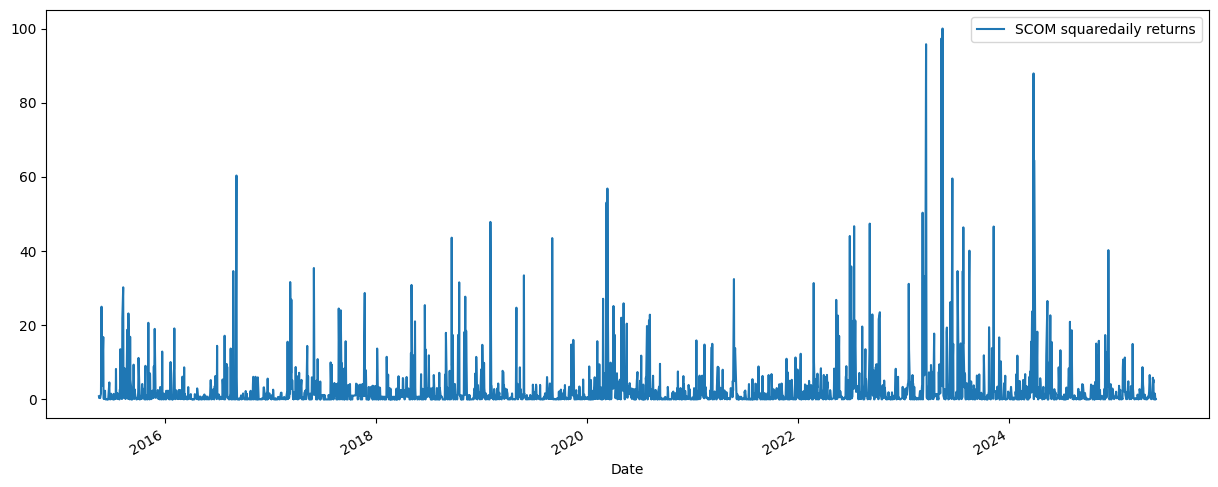

In [24]:
fig, ax = plt.subplots(figsize=(15, 6))
#Plot returns
(returns ** 2).plot(ax=ax, label="SCOM squaredaily returns")
#Plot SCOM 50 days rolling volatility
# rolling_volatility.plot(ax=ax, label='50-Day Rolling Volatility',linewidth=3)

plt.xlabel("Date")
ax.legend();
# Save the plot as an image file
plt.savefig("../Img/SCOM-squared-daily-returns.png", bbox_inches="tight") #bbox_inches="tight" ensures the whole plot is saved


We can note that our time series data is a good candidate because of the following:<br>
1.*Volatility Clustering* -  periods of high volatility followed by high volatility, and low volatility followed by low volatility <br>
2.*Spikes & Bursts* <br>
3.*Non-constant Variance (Heteroskedasticity):* The variance of the series isn’t constant across time.

**ACF plot** <br>
-An ACF plot tells us how a time series data is correlated with a lagged version of itself. From the plot below the squared returns have weak correlation among the first 3 lags.

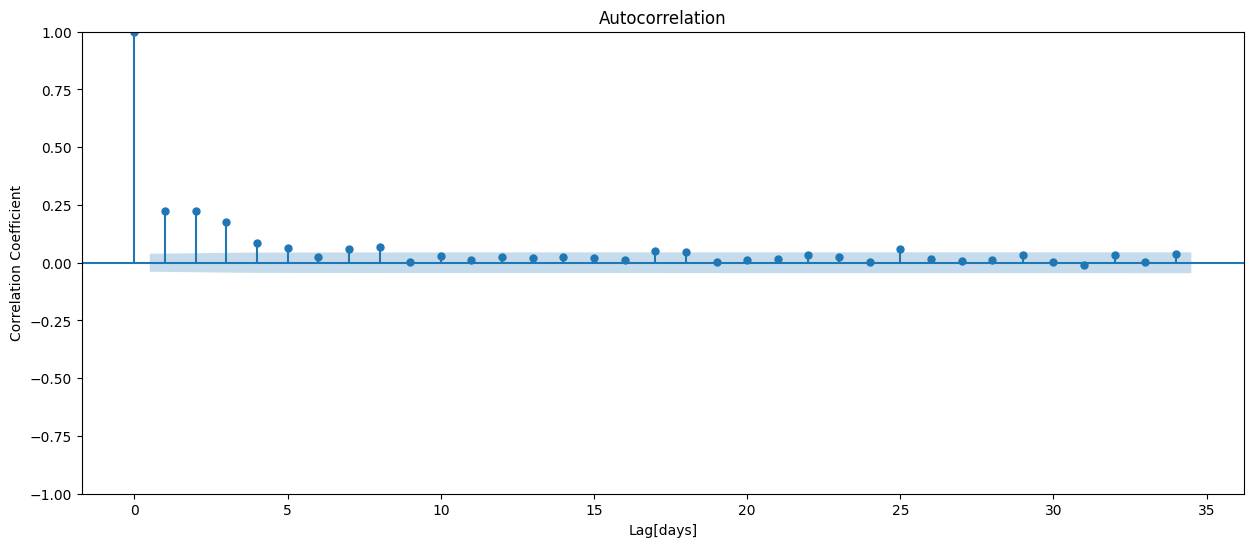

In [21]:
fig, ax = plt.subplots(figsize=(15, 6))
#Create ACF of squared returns
plot_acf(returns **2, ax=ax)
plt.xlabel("Lag[days]")
plt.ylabel("Correlation Coefficient");

**PACF plot** <br>
Shows the correlation between two time series points after the effect of shorter lags have been removed. The PACF plot cuts off after lag 3 hence it will the starting point for our the model.

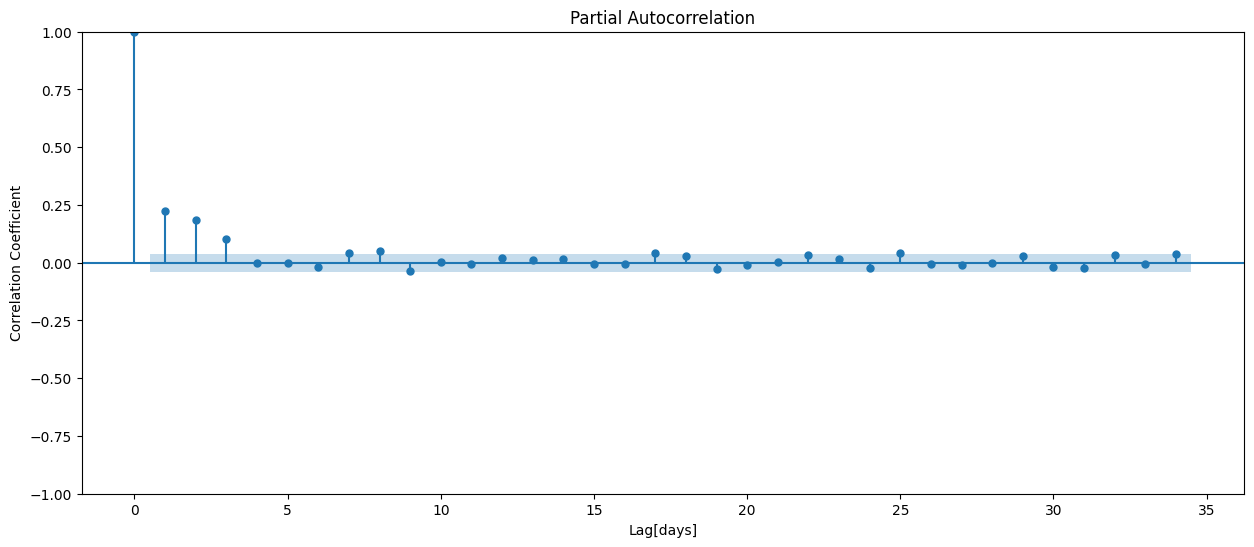

In [23]:
fig, ax = plt.subplots(figsize=(15, 6))
#Create PACF of squared returns
plot_pacf(returns **2, ax=ax)
plt.xlabel("Lag[days]")
plt.ylabel("Correlation Coefficient");